importando librerías

In [1]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, BatchNormalization, Add, GaussianNoise, Dropout
from keras.models import Model
from keras import regularizers
from keras import optimizers
import re

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


funciones de grafico y auc score

In [2]:
precisiones_globales=[]
def graf_model(train_history):
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    # summarize history for accuracy
    ax.plot(train_history.history['binary_accuracy'])
    ax.plot(train_history.history['val_binary_accuracy'])
    ax.set_title('model accuracy')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(train_history.history['loss'])
    ax2.plot(train_history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    plt.show()
def precision(model, registrar=False):
    y_pred = model.predict(train_dfX)
    train_auc = roc_auc_score(train_dfY, y_pred)
    y_pred = model.predict(val_dfX)
    val_auc = roc_auc_score(val_dfY, y_pred)
    print('Train AUC: ', train_auc)
    print('Vali AUC: ', val_auc)
    if registrar:
        precisiones_globales.append([train_auc,val_auc])

leyendo la data

In [3]:
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv("../input/titanic/test.csv")
train_dfX = train_df.drop(['PassengerId', 'Survived','Ticket'], axis=1)
train_dfY = train_df['Survived']
submission = test_df[['PassengerId']].copy()
test_df = test_df.drop(['PassengerId','Ticket'], axis=1)
print("Train shape : ",train_dfX.shape)
print("Test shape : ",test_df.shape)

Train shape :  (891, 9)
Test shape :  (418, 9)


cambiando a clases numerica los siguientes datos


In [4]:
train_dfX.Embarked[train_dfX.Embarked == 'S'] = 1
train_dfX.Embarked[train_dfX.Embarked == 'Q'] = 2
train_dfX.Embarked[train_dfX.Embarked == 'C'] = 3

test_df.Embarked[test_df.Embarked == 'S'] = 1
test_df.Embarked[test_df.Embarked == 'Q'] = 2
test_df.Embarked[test_df.Embarked == 'C'] = 3

train_dfX.Sex[train_dfX.Sex == 'male'] = 0
train_dfX.Sex[train_dfX.Sex == 'female'] = 1

test_df.Sex[test_df.Sex == 'male'] = 0
test_df.Sex[test_df.Sex == 'female'] = 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doi

volviendo la data arreglos

In [5]:
array_test=test_df.values
array_trainx=train_dfX.values

asignando valores numericos a la data de cabin dependiendo de la letra

In [6]:
for i in range(891):
    if pd.isnull(array_trainx[i][7]):
        array_trainx[i][7]=0
    elif (not pd.isnull(array_trainx[i][7])) and array_trainx[i][7][:1]=='A':
        array_trainx[i][7]=1
    elif (not pd.isnull(array_trainx[i][7])) and array_trainx[i][7][:1]=='B':
        array_trainx[i][7]=2
    elif (not pd.isnull(array_trainx[i][7])) and array_trainx[i][7][:1]=='C':
        array_trainx[i][7]=3
    elif (not pd.isnull(array_trainx[i][7])) and array_trainx[i][7][:1]=='D':
        array_trainx[i][7]=4
    elif (not pd.isnull(array_trainx[i][7])) and array_trainx[i][7][:1]=='E':
        array_trainx[i][7]=5
    elif (not pd.isnull(array_trainx[i][7])) and array_trainx[i][7][:1]=='F':
        array_trainx[i][7]=6
    elif (not pd.isnull(array_trainx[i][7])) and array_trainx[i][7][:1]=='G':
        array_trainx[i][7]=7
    else:
        array_trainx[i][7]=8
 

In [7]:
for i in range(418):
    if pd.isnull(array_test[i][7]):
        array_test[i][7]=0
    elif (not pd.isnull(array_test[i][7])) and array_test[i][7][:1]=='A':
        array_test[i][7]=1
    elif (not pd.isnull(array_test[i][7])) and array_test[i][7][:1]=='B':
        array_test[i][7]=2
    elif (not pd.isnull(array_test[i][7])) and array_test[i][7][:1]=='C':
        array_test[i][7]=3
    elif (not pd.isnull(array_test[i][7])) and array_test[i][7][:1]=='D':
        array_test[i][7]=4
    elif (not pd.isnull(array_test[i][7])) and array_test[i][7][:1]=='E':
        array_test[i][7]=5
    elif (not pd.isnull(array_test[i][7])) and array_test[i][7][:1]=='F':
        array_test[i][7]=6
    elif (not pd.isnull(array_test[i][7])) and array_test[i][7][:1]=='G':
        array_test[i][7]=7
    else:
        array_test[i][7]=0

haciendo one hot de los datos de cabin

In [8]:
traincabin=np.zeros((1,891))
cont1=0
for x in range(891):
    traincabin[0][x]=array_trainx[x][7]


one_hot_cabin=to_categorical(traincabin)
print(one_hot_cabin.shape)
one_hot_cabin=np.reshape(one_hot_cabin,(891,9))
one_hot_cabin=one_hot_cabin[:,[0,1,2,3,4,5,6,7]]
print(one_hot_cabin.shape)

(1, 891, 9)
(891, 8)


In [9]:
testcabin=np.zeros((1,418))
cont1=0
for x in range(418):
    testcabin[0][x]=array_test[x][7]


one_hot_cabintest=to_categorical(testcabin)
print(one_hot_cabintest.shape)
one_hot_cabintest=np.reshape(one_hot_cabintest,(418,8))

(1, 418, 8)


asignando valores numericos a cada titulo, los primeros 5 que mas aparecen y los que quedan agrupados en la misma clase numerica

In [10]:



for i in range(891):
    
    m = re.search(', (.+?) ', array_trainx[i][1])
    if m:
        found = m.group(1)
    #print(m.group(1))
    
for ii in range(418):
    
    mm = re.search(', (.+?) ', array_test[ii][1])
    if mm:
        found = mm.group(1)
        #print(m.group(1))

a = 'Mr.'    
b = 'Mrs.'
c = 'Miss.'
d = 'Ms.'
e = 'Master.'
f = 'Don.'
g = 'Rev.'
h = 'Dr.'
i = 'Mme.'
j = 'Major.'
k = 'Lady.'
l = 'Sir.'
z = 'Mlle.'
n = 'Col.'
o = 'Capt.'
p = 'Jonkheer.'
q = 'the'

auxnametrain=np.zeros((891,1))
for x in range(891):
    m = re.search(', (.+?) ', array_trainx[x][1])
    m=m.group(1)
    if (m==a):
        auxnametrain[x][0]=1
    elif (m==b):
        auxnametrain[x][0]=2
    elif (m==c):
        auxnametrain[x][0]=3
    elif (m==d):
        auxnametrain[x][0]=4
    elif (m==e):
        auxnametrain[x][0]=5
    else :
        auxnametrain[x][0]=6
        
        
auxnametest=np.zeros((418,1))
for xx in range(418):
    mm = re.search(', (.+?) ', array_test[xx][1])
    mm=mm.group(1)
    if (mm==a):
        auxnametest[xx][0]=1
    elif (mm==b):
        auxnametest[xx][0]=2
    elif (mm==c):
        auxnametest[xx][0]=3
    elif (mm==d):
        auxnametest[xx][0]=4
    elif (mm==e):
        auxnametest[xx][0]=5
    else :
        auxnametest[xx][0]=6
    '''
    elif (m==g):
        aux[x][0]=7
    elif (m==h):
        aux[x][0]=8
    elif (m==i):
        aux[x][0]=9
    elif (m==j):
        aux[x][0]=10
    elif (m==k):
        aux[x][0]=11
    elif (m==l):
        aux[x][0]=12
    elif (m==z):
        aux[x][0]=13
    elif (m==n):
        aux[x][0]=14
    elif (m==o):
        aux[x][0]=15
    elif (m==p):
        aux[x][0]=16
    elif (m==q):
        aux[x][0]=17 '''


creando one hot de los titulos

In [11]:
auxnametrain=auxnametrain.T

one_hot_name=to_categorical(auxnametrain)

one_hot_name=np.reshape(one_hot_name,(891,7))
one_hot_name= np.delete(one_hot_name, 0, 1)
#print(one_hot_name.shape)
#print(one_hot_name)

auxnametest=auxnametest.T

one_hot_nametest=to_categorical(auxnametest)

one_hot_nametest=np.reshape(one_hot_nametest,(418,7))
one_hot_nametest= np.delete(one_hot_nametest, 0, 1)
#print(one_hot_nametest.shape)
#print(one_hot_name)


sacar promedios de edad por titulo


In [12]:

sumaMR=0
contMR=0
sumaMRs=0
contMRs=0
sumaMiss=0
contMiss=0
sumaMs=0
contMs=0
sumaMaster=0
contMaster=0
sumaotros=0
contotros=0
for x in range(891):
    if (not np.isnan(array_trainx[x][3])) and auxnametrain[0][x]==1:
        sumaMR=sumaMR+array_trainx[x][3]
        contMR=contMR+1
        
    elif (not np.isnan(array_trainx[x][3])) and auxnametrain[0][x]==2 :
        sumaMRs=sumaMRs+array_trainx[x][3]
        contMRs=contMRs+1
   
    elif (not np.isnan(array_trainx[x][3])) and auxnametrain[0][x]==3 :
        sumaMiss=sumaMiss+array_trainx[x][3]
        contMiss=contMiss+1
    
    elif (not np.isnan(array_trainx[x][3])) and auxnametrain[0][x]==4 :
        sumaMs=sumaMs+array_trainx[x][3]
        contMs=contMs+1
        
    elif (not np.isnan(array_trainx[x][3])) and auxnametrain[0][x]==5 :
        sumaMaster=sumaMaster+array_trainx[x][3]
        contMaster=contMaster+1
        
    elif (not np.isnan(array_trainx[x][3])) and auxnametrain[0][x]==6 :
        sumaotros=sumaotros+array_trainx[x][3]
        contotros=contotros+1

        
        
        
        
promMR=sumaMR/contMR
promMRs=sumaMRs/contMRs
promMiss=sumaMiss/contMiss
promMs=sumaMs/contMs
promMaster=sumaMaster/contMaster
promotros=sumaotros/contotros

print("el promdedio de edad en el training set de los MR es: " + str(promMR))
print("el promdedio de edad en el training set de los MRs es: " + str(promMRs))
print("el promdedio de edad en el training set de las Miss es: " + str(promMiss))
print("el promdedio de edad en el training set de los Ms es: " + str(promMs))
print("el promdedio de edad en el training set de los Master es: " + str(promMaster))
print("el promdedio de edad en el training set de otros es: " + str(promotros))



sumaMRtest=0
contMRtest=0
sumaMRstest=0
contMRstest=0
sumaMisstest=0
contMisstest=0
sumaMstest=0
contMstest=0
sumaMastertest=0
contMastertest=0
sumaotrostest=0
contotrostest=0

for x in range(418):
         
    if (not np.isnan(array_test[x][3])) and auxnametest[0][x]==1:
        sumaMRtest=sumaMRtest+array_test[x][3]
        contMRtest=contMRtest+1
        
    elif (not np.isnan(array_test[x][3])) and auxnametest[0][x]==2 :
        sumaMRstest=sumaMRstest+array_test[x][3]
        contMRstest=contMRstest+1
   
    elif (not np.isnan(array_test[x][3])) and auxnametest[0][x]==3 :
        sumaMisstest=sumaMisstest+array_test[x][3]
        contMisstest=contMisstest+1
    
    elif (not np.isnan(array_test[x][3])) and auxnametest[0][x]==4 :
        sumaMstest=sumaMstest+array_test[x][3]
        contMstest=contMstest+1
        
    elif (not np.isnan(array_test[x][3])) and auxnametest[0][x]==5 :
        sumaMastertest=sumaMastertest+array_test[x][3]
        contMastertest=contMastertest+1
        
    elif (not np.isnan(array_test[x][3])) and auxnametest[0][x]==6 :
        sumaotrostest=sumaotrostest+array_test[x][3]
        contotrostest=contotrostest+1
        
promMRtest=sumaMRtest/contMRtest
promMRstest=sumaMRstest/contMRstest
promMisstest=sumaMisstest/contMisstest
#promMstest=sumaMstest/contMstest
promMastertest=sumaMastertest/contMastertest
promotrostest=sumaotrostest/contotrostest

print("el promdedio de edad en el test set de los MR es: " + str(promMRtest))
print("el promdedio de edad en el test set de los MRs es: " + str(promMRstest))
print("el promdedio de edad en el test set de las Miss es: " + str(promMisstest))
#print("el promdedio de edad en el test set de los Ms es: " + str(promMstest))
print("el promdedio de edad en el test set de los Master es: " + str(promMastertest))
print("el promdedio de edad en el test set de otros es: " + str(promotrostest))


el promdedio de edad en el training set de los MR es: 32.368090452261306
el promdedio de edad en el training set de los MRs es: 35.898148148148145
el promdedio de edad en el training set de las Miss es: 21.773972602739725
el promdedio de edad en el training set de los Ms es: 28.0
el promdedio de edad en el training set de los Master es: 4.574166666666667
el promdedio de edad en el training set de otros es: 42.96
el promdedio de edad en el test set de los MR es: 32.0
el promdedio de edad en el test set de los MRs es: 38.903225806451616
el promdedio de edad en el test set de las Miss es: 21.774843750000002
el promdedio de edad en el test set de los Master es: 7.406470588235294
el promdedio de edad en el test set de otros es: 43.833333333333336


asignar edades promedio dependiendo del titulo a auqellos pasajeros sin edad 

In [13]:
for x in range(891):
    if  np.isnan(array_trainx[x][3]) and auxnametrain[0][x]==1 :
        array_trainx[x][3]=promMR
    elif np.isnan(array_trainx[x][3]) and auxnametrain[0][x]==2 :
        array_trainx[x][3]=promMRs
    elif np.isnan(array_trainx[x][3]) and auxnametrain[0][x]==3 :
        array_trainx[x][3]=promMiss
    elif np.isnan(array_trainx[x][3]) and auxnametrain[0][x]==4 :
        array_trainx[x][3]=promMs
    elif np.isnan(array_trainx[x][3]) and auxnametrain[0][x]==5 :
        array_trainx[x][3]=promMaster
    elif np.isnan(array_trainx[x][3]) and auxnametrain[0][x]==6:
        array_trainx[x][3]=promotros
        

for xx in range(418):
   
    if  np.isnan(array_test[xx][3]) and auxnametest[0][xx]==1 :
        array_test[xx][3]=promMRtest
    elif np.isnan(array_test[xx][3]) and auxnametest[0][xx]==2 :
        array_test[xx][3]=promMRstest
    elif np.isnan(array_test[xx][3]) and auxnametest[0][xx]==3 :
        array_test[xx][3]=promMisstest
    elif np.isnan(array_test[xx][3]) and auxnametest[0][xx]==4 :
        array_test[xx][3]=promotrostest
    elif np.isnan(array_test[xx][3]) and auxnametest[0][xx]==5 :
        array_test[xx][3]=promMastertest
    elif np.isnan(array_test[xx][3]) and auxnametest[0][xx]==6:
        array_test[xx][3]=promotrostest
        


haciendo one hot de embarked

In [14]:
aux=np.zeros((1,891))
auxtest=np.zeros((1,418))

for x in range(891):
    
    if not np.isnan(array_trainx[x][8]):
        aux[0][x]=array_trainx[x][8]
    else:
        aux[0][x]=0


for xx in range(418):
    
    if not np.isnan(array_test[xx][8]):
        auxtest[0][xx]=array_test[xx][8]
    else:
        auxtest[0][xx]=0
one_hot_embarked=to_categorical(aux)
#print(one_hot_embarked.shape)
one_hot_embarked=np.reshape(one_hot_embarked,(891,4))
#print(one_hot_embarked.shape)
#print(one_hot_embarked)

one_hot_embarkedtest=to_categorical(auxtest)
one_hot_embarkedtest=np.reshape(one_hot_embarkedtest,(418,4))

haciendo one hot p class

In [15]:
aux2=np.zeros((1,891))
cont1=0
for x in range(891):
    
    if not np.isnan(array_trainx[x][0]):
        aux2[0][x]=array_trainx[x][0]
        
    else:
        aux2[0][x]=0


one_hot_pclass=to_categorical(aux2)
one_hot_pclass=np.reshape(one_hot_pclass,(891,4))
one_hot_pclass= np.delete(one_hot_pclass, 0, 1)


auxtest2=np.zeros((1,418))
cont3=0
for xx in range(418):
    
    if not np.isnan(array_test[xx][0]):
        auxtest2[0][xx]=array_test[xx][0]
        
    else:
        auxtest2[0][xx]=0


one_hot_pclasstest=to_categorical(auxtest2)
one_hot_pclasstest=np.reshape(one_hot_pclasstest,(418,4))
one_hot_pclasstest= np.delete(one_hot_pclasstest, 0, 1)

agrupando toda la data en un arreglo

In [16]:
trainx=np.zeros((891,26))#no ticket aun
for x in range(891):
    trainx[x][0]=one_hot_pclass[x][0] #class 1
    trainx[x][1]=one_hot_pclass[x][1] #class 2
    trainx[x][2]=one_hot_pclass[x][2] #class 3
    trainx[x][3]=array_trainx[x][2] #sex
    trainx[x][4]=array_trainx[x][3] #age
    trainx[x][5]=array_trainx[x][4] #sib
    trainx[x][6]=array_trainx[x][5] #parch
    trainx[x][7]=array_trainx[x][6] #fare
    trainx[x][8]=one_hot_embarked[x][0]
    trainx[x][9]=one_hot_embarked[x][1]
    trainx[x][10]=one_hot_embarked[x][2]
    trainx[x][11]=one_hot_embarked[x][3]
    trainx[x][12]=one_hot_name[x][0] #name
    trainx[x][13]=one_hot_name[x][1] #name
    trainx[x][14]=one_hot_name[x][2] #name
    trainx[x][15]=one_hot_name[x][3] #name
    trainx[x][16]=one_hot_name[x][4] #name
    trainx[x][17]=one_hot_name[x][5] #name
    trainx[x][18]=one_hot_cabin[x][0] #cabin
    trainx[x][19]=one_hot_cabin[x][1] #cabin
    trainx[x][20]=one_hot_cabin[x][2] #cabin
    trainx[x][21]=one_hot_cabin[x][3] #cabin
    trainx[x][22]=one_hot_cabin[x][4] #cabin
    trainx[x][23]=one_hot_cabin[x][5] #cabin
    trainx[x][24]=one_hot_cabin[x][6] #cabin
    trainx[x][25]=one_hot_cabin[x][7] #cabin
    

print(trainx.shape)

testarray=np.zeros((418,26))#sin nombre  ni ticket aun
for xx in range(418):
    testarray[xx][0]=one_hot_pclasstest[xx][0] #class 1
    testarray[xx][1]=one_hot_pclasstest[xx][1] #class 2
    testarray[xx][2]=one_hot_pclasstest[xx][2] #class 3
    testarray[xx][3]=array_test[xx][2] #sex
    testarray[xx][4]=array_test[xx][3] #age
    testarray[xx][5]=array_test[xx][4] #sib
    testarray[xx][6]=array_test[xx][5] #parch
    testarray[xx][7]=array_test[xx][6] #fare
    testarray[xx][8]=one_hot_embarkedtest[xx][0]
    testarray[xx][9]=one_hot_embarkedtest[xx][1]
    testarray[xx][10]=one_hot_embarkedtest[xx][2]
    testarray[xx][11]=one_hot_embarkedtest[xx][3]
    testarray[xx][12]=one_hot_nametest[xx][0] #name
    testarray[xx][13]=one_hot_nametest[xx][1] #name
    testarray[xx][14]=one_hot_nametest[xx][2] #name
    testarray[xx][15]=one_hot_nametest[xx][3] #name
    testarray[xx][16]=one_hot_nametest[xx][4] #name
    testarray[xx][17]=one_hot_nametest[xx][5] #name
    testarray[xx][18]=one_hot_cabintest[xx][0] #cabin
    testarray[xx][19]=one_hot_cabintest[xx][1] #cabin
    testarray[xx][20]=one_hot_cabintest[xx][2] #cabin
    testarray[xx][21]=one_hot_cabintest[xx][3] #cabin
    testarray[xx][22]=one_hot_cabintest[xx][4] #cabin
    testarray[xx][23]=one_hot_cabintest[xx][5] #cabin
    testarray[xx][24]=one_hot_cabintest[xx][6] #cabin
    testarray[xx][25]=one_hot_cabintest[xx][7] #cabin

(891, 26)


normalizando

In [17]:
sc = StandardScaler()
trainx = sc.fit_transform(trainx)
test = sc.fit_transform(testarray)

separando en validacion y train

In [18]:
train_dfX,val_dfX,train_dfY, val_dfY = train_test_split(trainx,train_dfY , test_size=0.1, stratify=train_dfY)
print("Entrnamiento: ",train_dfX.shape)
print("Validacion : ",val_dfX.shape)

Entrnamiento:  (801, 26)
Validacion :  (90, 26)


modelo

In [19]:
def func_model():   
    inp = Input(shape=(26,)) 
    x=Dense(90, activation="relu", kernel_initializer='glorot_normal', bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01))(inp)
    #x=Dropout(0.6)(x)
    x=Dense(72, activation="relu", kernel_initializer='glorot_normal', bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01))(x)
    x=Dropout(0.6)(x)
    x=Dense(54, activation="relu", kernel_initializer='glorot_normal', bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01))(x)
    x=Dropout(0.5)(x)
    x=Dense(36, activation="relu", kernel_initializer='glorot_normal', bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01))(x)
    x=Dropout(0.4)(x)
    x=Dense(18, activation="relu", kernel_initializer='glorot_normal', bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01))(x)
    #x=Dropout(0.25)(x)
    x=Dense(9, activation="relu", kernel_initializer='glorot_normal', bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01))(x) 
    x=Dropout(0.1)(x)
    x=Dense(4, activation="relu", kernel_initializer='glorot_normal', bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01))(x) 
    x=Dense(1, activation="sigmoid", kernel_initializer='glorot_normal', bias_initializer='zeros')(x)
    model = Model(inputs=inp, outputs=x)
    #sgd = optimizers.SGD(lr=0.0001, clipnorm=1.)
    sgd = optimizers.SGD(lr=0.001, decay=0.001)
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
    return model
model = func_model()
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                2430      
_________________________________________________________________
dense_2 (Dense)              (None, 72)                6552      
_________________________________________________________________
dropout_1 (Dropout)          (None, 72)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 54)                3942      
_________________________________________________________________
dropout_2 (Dropout)          (None, 54)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 36)                1980

ejecutando el modelo

In [20]:
train_history = model.fit(train_dfX, train_dfY, epochs=150, validation_data=(val_dfX, val_dfY))

Train on 801 samples, validate on 90 samples
Epoch 1/150
801/801 [==============================] - 0s 565us/step - loss: 3.3677 - binary_accuracy: 0.4057 - val_loss: 3.2949 - val_binary_accuracy: 0.6333
Epoch 2/150
801/801 [==============================] - 0s 65us/step - loss: 3.2986 - binary_accuracy: 0.5456 - val_loss: 3.2608 - val_binary_accuracy: 0.6667
Epoch 3/150
801/801 [==============================] - 0s 66us/step - loss: 3.2535 - binary_accuracy: 0.6242 - val_loss: 3.2306 - val_binary_accuracy: 0.6667
Epoch 4/150
801/801 [==============================] - 0s 71us/step - loss: 3.2177 - binary_accuracy: 0.6667 - val_loss: 3.2021 - val_binary_accuracy: 0.6333
Epoch 5/150
801/801 [==============================] - 0s 69us/step - loss: 3.1845 - binary_accuracy: 0.6592 - val_loss: 3.1743 - val_binary_accuracy: 0.6222
Epoch 6/150
801/801 [==============================] - 0s 65us/step - loss: 3.1552 - binary_accuracy: 0.6579 - val_loss: 3.1468 - val_binary_accuracy: 0.6222
Epoch 

Grafico y AUC

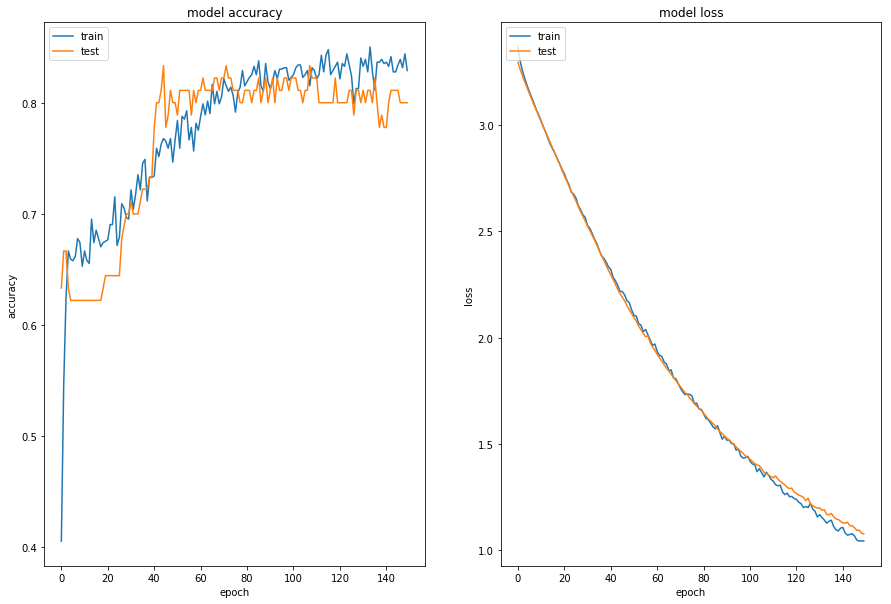

Train AUC:  0.887041896899603
Vali AUC:  0.8457142857142858


In [21]:
graf_model(train_history)
precision(model, True)

predecir test


In [22]:

y_test = model.predict(test)
for i in range(0, 418):
    if y_test[i]<=0.5:
        y_test[i]=0
    else:
        y_test[i]=1
submission['Survived'] = y_test.astype(int)
print(submission)
submission.to_csv('submission.csv', index=False)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
